The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 权重衰减
:label:`sec_weight_decay`

前一节我们描述了过拟合的问题，本节我们将介绍一些正则化模型的技术。
我们总是可以通过去收集更多的训练数据来缓解过拟合。
但这可能成本很高，耗时颇多，或者完全超出我们的控制，因而在短期内不可能做到。
假设我们已经拥有尽可能多的高质量数据，我们便可以将重点放在正则化技术上。

回想一下，在多项式回归的例子（ :numref:`sec_model_selection`）中，
我们可以通过调整拟合多项式的阶数来限制模型的容量。
实际上，限制特征的数量是缓解过拟合的一种常用技术。
然而，简单地丢弃特征对这项工作来说可能过于生硬。
我们继续思考多项式回归的例子，考虑高维输入可能发生的情况。
多项式对多变量数据的自然扩展称为*单项式*（monomials），
也可以说是变量幂的乘积。
单项式的阶数是幂的和。
例如，$x_1^2 x_2$和$x_3 x_5^2$都是3次单项式。

注意，随着阶数$d$的增长，带有阶数$d$的项数迅速增加。
给定$k$个变量，阶数为$d$的项的个数为
${k - 1 + d} \choose {k - 1}$，即$C^{k-1}_{k-1+d} = \frac{(k-1+d)!}{(d)!(k-1)!}$。
因此即使是阶数上的微小变化，比如从$2$到$3$，也会显著增加我们模型的复杂性。
仅仅通过简单的限制特征数量（在多项式回归中体现为限制阶数），可能仍然使模型在过简单和过复杂中徘徊，
我们需要一个更细粒度的工具来调整函数的复杂性，使其达到一个合适的平衡位置。
## 范数与权重衰减

在 :numref:`subsec_lin-algebra-norms`中，
我们已经描述了$L_2$范数和$L_1$范数，
它们是更为一般的$L_p$范数的特殊情况。
(~~权重衰减是最广泛使用的正则化的技术之一~~)
在训练参数化机器学习模型时，
*权重衰减*（weight decay）是最广泛使用的正则化的技术之一，
它通常也被称为$L_2$*正则化*。
这项技术通过函数与零的距离来衡量函数的复杂度，
因为在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）
在某种意义上是最简单的。
但是我们应该如何精确地测量一个函数和零之间的距离呢？
没有一个正确的答案。
事实上，函数分析和巴拿赫空间理论的研究，都在致力于回答这个问题。

一种简单的方法是通过线性函数
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
中的权重向量的某个范数来度量其复杂性，
例如$\| \mathbf{w} \|^2$。
要保证权重向量比较小，
最常用方法是将其范数作为惩罚项加到最小化损失的问题中。
将原来的训练目标*最小化训练标签上的预测损失*，
调整为*最小化预测损失和惩罚项之和*。
现在，如果我们的权重向量增长的太大，
我们的学习算法可能会更集中于最小化权重范数$\| \mathbf{w} \|^2$。
这正是我们想要的。
让我们回顾一下 :numref:`sec_linear_regression`中的线性回归例子。
我们的损失由下式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

回想一下，$\mathbf{x}^{(i)}$是样本$i$的特征，
$y^{(i)}$是样本$i$的标签，
$(\mathbf{w}, b)$是权重和偏置参数。
为了惩罚权重向量的大小，
我们必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，
但是模型应该如何平衡这个新的额外惩罚的损失？
实际上，我们通过*正则化常数*$\lambda$来描述这种权衡，
这是一个非负超参数，我们使用验证数据拟合：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

对于$\lambda = 0$，我们恢复了原来的损失函数。
对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。
这里我们仍然除以$2$：当我们取一个二次函数的导数时，
$2$和$1/2$会抵消，以确保更新表达式看起来既漂亮又简单。
为什么在这里我们使用平方范数而不是标准范数（即欧几里得距离）？
我们这样做是为了便于计算。
通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。
这使得惩罚的导数很容易计算：导数的和等于和的导数。

此外，为什么我们首先使用$L_2$范数，而不是$L_1$范数。
事实上，这个选择在整个统计领域中都是有效的和受欢迎的。
$L_2$正则化线性模型构成经典的*岭回归*（ridge regression）算法，
$L_1$正则化线性回归是统计学中类似的基本模型，
通常被称为*套索回归*（lasso regression）。
使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。
这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。
在实践中，这可能使它们对单个变量中的观测误差更为稳定。
相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上，
而将其他权重清除为零。
这称为*特征选择*（feature selection），这可能是其他场景下需要的。

使用与 :eqref:`eq_linreg_batch_update`中的相同符号，
$L_2$正则化回归的小批量随机梯度下降更新如下式：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。
然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。
这就是为什么这种方法有时被称为*权重衰减*。
我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。
与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。
较小的$\lambda$值对应较少约束的$\mathbf{w}$，
而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，
在神经网络的不同层中也会有所不同。
通常，网络输出层的偏置项不会被正则化。

## 高维线性回归

我们通过一个简单的例子来演示权重衰减。


In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。


In [6]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size,is_train=True)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

### [**初始化模型参数**]

首先，我们将定义一个函数来随机初始化模型参数。


In [7]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### (**定义$L_2$范数惩罚**)

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。


In [8]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### [**定义训练代码实现**]

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。
从 :numref:`chap_linear`以来，线性网络和平方损失没有变化，
所以我们通过`d2l.linreg`和`d2l.squared_loss`导入它们。
唯一的变化是损失现在包括了惩罚项。


In [10]:
def train(lambd):
    w, b = init_params()
    ## lambda argument_list:expersion
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### [**忽略正则化直接训练**]

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。
注意，这里训练误差有了减少，但测试误差没有减少，
这意味着出现了严重的过拟合。


w的L2范数是： 12.735541343688965


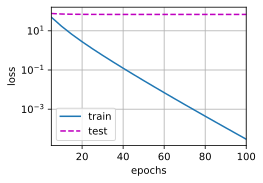

In [11]:
train(lambd=0)

### [**使用权重衰减**]

下面，我们使用权重衰减来运行代码。
注意，在这里训练误差增大，但测试误差减小。
这正是我们期望从正则化中得到的效果。


w的L2范数是： 0.3964109420776367


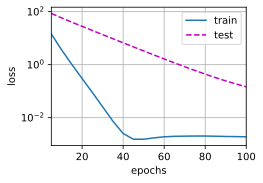

In [12]:
train(lambd=3)

## [**简洁实现**]

由于权重衰减在神经网络优化中很常用，
深度学习框架为了便于我们使用权重衰减，
将权重衰减集成到优化算法中，以便与任何损失函数结合使用。
此外，这种集成还有计算上的好处，
允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。
由于更新的权重衰减部分仅依赖于每个参数的当前值，
因此优化器必须至少接触每个参数一次。


在下面的代码中，我们在实例化优化器时直接通过`weight_decay`指定weight decay超参数。
默认情况下，PyTorch同时衰减权重和偏移。
这里我们只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减。


In [14]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

[**这些图看起来和我们从零开始实现权重衰减时的图相同**]。
然而，它们运行得更快，更容易实现。
对于更复杂的问题，这一好处将变得更加明显。


w的L2范数： 13.521913528442383


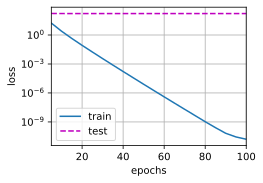

In [15]:
train_concise(0)

w的L2范数： 0.37344688177108765


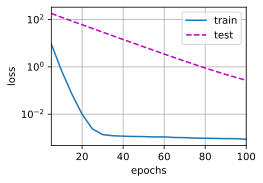

In [16]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。
此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。
例如，[再生核希尔伯特空间（RKHS）](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
允许在非线性环境中应用为线性函数引入的工具。
不幸的是，基于RKHS的算法往往难以应用到大型、高维的数据。
在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

## 小结

* 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

## 练习

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数。观察到了什么？
1. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的Frobenius范数）？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？


[Discussions](https://discuss.d2l.ai/t/1808)
